<a href="https://colab.research.google.com/github/avkornaev/Cells_counter/blob/main/PlayWithUncertainty_Vol6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solver

In [1]:
Solver = 'Colab' #'Container', 'Local', 'Colab'
isFirstStart = True

# Install libraries (with the very first run)

In [2]:
if isFirstStart:
    #!pip install numpy --upgrade
    #!pip install scipy --upgrade 
#     !pip install torch --upgrade 
#     !pip install torchvision --upgrade 
#     !pip install openpyxl
#     !pip install mlxtend
#     !pip install efficientnet_pytorch
    !pip install --quiet "tabulate" "ipython[notebook]>=8.0.0, <8.12.0" "pytorch-lightning>=1.4, <2.0.0" "torchvision" "setuptools==67.4.0" "seaborn" "torch>=1.8.1, <1.14.0" "matplotlib" "torchmetrics>=0.7, <0.12" "lightning>=2.0.0rc0"
    !pip install lightning
    !pip install neptune # -client numpy==1.19.5 torch==1.13.1 torchvision==0.14.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.3/793.3 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.0/546.0 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Import libraries

In [3]:
import os
import urllib.request
from types import SimpleNamespace
from urllib.error import HTTPError

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import seaborn as sns
import tabulate
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

%matplotlib inline
from IPython.display import HTML, display
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

#observation
import neptune.new as neptune
from neptune.new.types import File

#MOUNT DRIVE
if Solver =='Colab':
    from google.colab import drive
    drive.mount('/drive', force_remount=True)

<ipython-input-3-771bdb359ad2>:31: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


Mounted at /drive


In [4]:
run = neptune.init_run(
    project="smkornaeva/Play-with-uncertainty",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5ZjE1YmI4Ni0yZmQ2LTRjNDAtYjhhYy01NzUyZTIzMWJhODcifQ==",
)  # your credentials

<ipython-input-4-a171d1b586d0>:7: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/smkornaeva/Play-with-uncertainty/e/PLAY2-139


## Initialization

Device config

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Settings

In [6]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models")

# Function for setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42


In [7]:
DATASET = 'CIFAR-10'#'Hymenoptera'# or 'PetImages','CIFAR-10'
LOSS_FUN = 'CrossEntropy'#'CrossEntropyWithU' #or 'CrossEntropy'
ARCHITECTURE = 'vit_b_16'#'EffNet'# 'ResNet18'# 'ViViT' # 'vit_b_16'
PRETRAINED_NET = True
SAVE_RES = True
START_WITH_SAVED = True #download saved model

SIZE = 224 #image size

NUM_CLASSES = 10

THRESHOLD_RATIO = torch.linspace(0,0.99,10)

NOISE_IN_LABELS_RATIO = 0.5

num_epochs = 3
batch_size = 15
img_channels = 3

lr = 1E-1
step_size = 50
gamma = 0.5

#Set specific learning rates in the network layers
N_LAYERS_FOR_LR_CORRECTION = 0#number of the last few layers of the network
lr_mult = 1E+0 # learning rate multiplier

#Transformer settings
CROP_SIZE = 16
FRAME_LENGTH = 1
HEADS = 7
DIM = 192
DIM_HEAD = 64
DROPOUT = 0.5
EMB_DROPOUT = 0.0

parameters = {
    "lr": lr,
    "step_size":step_size,
    "gamma":gamma,
    "dataSet": DATASET,
    "bs": batch_size,
    "num_epochs": num_epochs,
    "input_sz": [img_channels, SIZE, SIZE],
    "n_classes": NUM_CLASSES,
    "criterion": LOSS_FUN,
    "model_filename": ARCHITECTURE,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
}

Download pretrained models from GitHub

In [24]:
# # Github URL where saved models are stored for this tutorial
# base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial5/"
# # Files to download
# pretrained_files = [
#     "GoogleNet.ckpt",
#     "ResNet.ckpt",
#     "ResNetPreAct.ckpt",
#     "DenseNet.ckpt",
#     "tensorboards/GoogleNet/events.out.tfevents.googlenet",
#     "tensorboards/ResNet/events.out.tfevents.resnet",
#     "tensorboards/ResNetPreAct/events.out.tfevents.resnetpreact",
#     "tensorboards/DenseNet/events.out.tfevents.densenet",
# ]
# # Create checkpoint path if it doesn't exist yet
# os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# # For each file, check whether it already exists. If not, try downloading it.
# for file_name in pretrained_files:
#     file_path = os.path.join(CHECKPOINT_PATH, file_name)
#     if "/" in file_name:
#         os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
#     if not os.path.isfile(file_path):
#         file_url = base_url + file_name
#         print(f"Downloading {file_url}...")
#         try:
#             urllib.request.urlretrieve(file_url, file_path)
#         except HTTPError as e:
#             print(
#                 "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
#                 e,
#             )

Normalization

In [25]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0, 1, 2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0, 1, 2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


In [9]:
# if DATASET == 'CIFAR-10':
#     mean = np.array([0.491,0.482,0.447])
#     std = np.array([0.247,0.243,0.261])
# else:
#     mean = np.array([0.485,0.456,0.406])
#     std = np.array([0.229,0.224,0.255])

## Log parameters

In [10]:
run["config/hyperparameters"] = parameters

<ipython-input-10-3ec0c705e318>:1: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'list'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run["config/perparameters"] = parameters
<ipython-input-10-3ec0c705e318>:1: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'torch.device'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run["config/perparameters"] = parameters


# Create data sets and data loaders

## Path
Hymenoptera_data: <https://download.pytorch.org/tutorial/hymenoptera_data.zip>

CIFAR-10 https://www.kaggle.com/competitions/cifar-10/data

## Transforms

Inputs transforms

In [27]:
data_transforms = {'train': transforms.Compose(
    [transforms.RandomResizedCrop(SIZE,scale=(6E-1, 1E-0)),
    transforms.RandomRotation(15),
    transforms.RandomAdjustSharpness(2,p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(DATA_MEANS, DATA_STD),
    transforms.RandomErasing(p=0.5,scale=(5E-2, 1E-1),value='random', inplace=False)]),
    'validation':transforms.Compose(
    [transforms.RandomResizedCrop(SIZE,scale=(8E-1, 1E-0)),
    transforms.ToTensor(),
    transforms.Normalize(DATA_MEANS, DATA_STD)]),
    'test': transforms.Compose(
    [transforms.RandomResizedCrop(SIZE,scale=(8E-1, 1E-0)),
    transforms.ToTensor(),
    transforms.Normalize(DATA_MEANS, DATA_STD)])}

Labels transform (noise in labels)

In [14]:
def randomLabelNoise(labels, phase, num_classes=10, p=0):
    '''
    phase is 'train' or 'test'
    '''
#     if phase == 'train':
#         a = torch.randperm(len(labels)) # shuffled list
#         for i in a[:np.int(np.round(len(labels)*p))]:
#             labels[i] = torch.randint(0, NUM_CLASSES,(1,1))
#     return labels
    if phase == 'train':
        a = torch.randperm(len(labels)) # shuffled list
        for i in a[:np.int(np.round(len(labels)*p))]:
            if labels[i] == 1:
                labels[i] = 9
            elif labels[i] == 9:
                labels[i] = 1
            elif labels[i] == 4:
                labels[i] = 7
            elif labels[i] == 7:
                labels[i] = 4
            elif labels[i] == 3:
                labels[i] = 5
            elif labels[i] == 5:
                labels[i] = 3
            # if labels[i] < 5:
            #     labels[i] = torch.randint(0, 5,(1,1))
    return labels

def similarLabelNoise(labels, phase, num_classes=10, p=0):
    '''
    phase is 'train' or 'test'
    '''
#     if phase == 'train':
#         a = torch.randperm(len(labels)) # shuffled list
#         for i in a[:np.int(np.round(len(labels)*p))]:
#             labels[i] = torch.randint(0, NUM_CLASSES,(1,1))
#     return labels
    if phase == 'train':
        a = torch.randperm(len(labels)) # shuffled list
        for i in a[:np.int(np.round(len(labels)*p))]:
            if labels[i] == 1:
                labels[i] = 9
            elif labels[i] == 9:
                labels[i] = 1
            elif labels[i] == 4:
                labels[i] = 7
            elif labels[i] == 7:
                labels[i] = 4
            elif labels[i] == 3:
                labels[i] = 5
            elif labels[i] == 5:
                labels[i] = 3
            # if labels[i] < 5:
            #     labels[i] = torch.randint(0, 5,(1,1))
    return labels

## Data sets and data loaders: training, validation, and test

In [34]:
# Training and validatioin sets
train_dataset = CIFAR10(root=DATASET_PATH, train=True,
                      transform=data_transforms['train'], download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True,
                      transform=data_transforms['validation'], download=True)
L.seed_everything(42)
samples4val = len(train_dataset) // 10
samples4train = len(train_dataset) - samples4val
train_set, _ = torch.utils.data.random_split(train_dataset, 
                                             [samples4train, samples4val])
L.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset,
                                             [samples4train, samples4val])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, 
                   transform=data_transforms['test'], download=True)

# Dataloaders
train_loader = data.DataLoader(train_set, batch_size=batch_size, drop_last=True,
                               pin_memory=True, shuffle=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=batch_size, drop_last=False,
                               pin_memory=True, shuffle=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=batch_size, drop_last=False,
                               pin_memory=True, shuffle=False, num_workers=4)

image_datasets = {'train': train_set, 'validation': val_set, 'test': test_set}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','validation','test']}
dataloaders = {'train': train_loader, 'validation': val_loader, 'test': testloader}
class_names = ['plane', 'car', 'bird', 'cat',
                'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42


Files already downloaded and verified


In [35]:
dataset_sizes

{'train': 45000, 'validation': 5000, 'test': 10000}

## Visualization

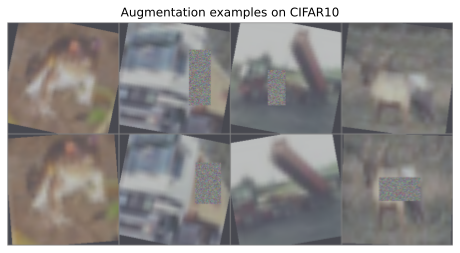

In [37]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [data_transforms['train'](img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

Training

In [38]:
inputs_train, classes_train = next(iter(dataloaders['train']))
#inputs_train = labelNoise(inputs_train, 'train', num_classes=NUM_CLASSES, p=NOISE_IN_LABELS_RATIO)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


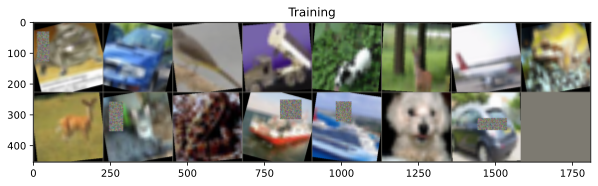

['cat', 'car', 'bird', 'truck', 'dog', 'deer', 'plane', 'frog', 'deer', 'cat', 'frog', 'ship', 'ship', 'dog', 'car']


In [39]:
fig = plt.figure(figsize=(10, 10))
out = torchvision.utils.make_grid(inputs_train)
imshow(out,title='Training')
print([class_names[x] for x in classes_train])

**Test**

In [40]:
inputs_test, classes_test = next(iter(dataloaders['test']))

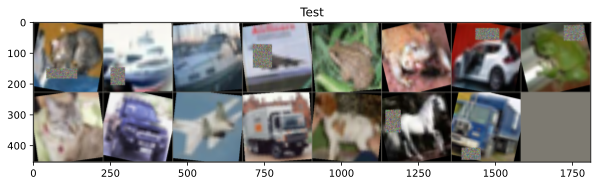

['cat', 'ship', 'ship', 'plane', 'frog', 'frog', 'car', 'frog', 'cat', 'car', 'plane', 'truck', 'dog', 'horse', 'truck']


In [41]:
fig = plt.figure(figsize=(10, 10))
out = torchvision.utils.make_grid(inputs_test)
imshow(out, title='Test')
print([class_names[x] for x in classes_test])

## Log the dataset details

In [42]:
run["config/dataset/path"] = data_dir
run["config/dataset/transforms"] = data_transforms
run["config/dataset/size"] = dataset_sizes

# Model architecture

A network outputs predicions when LOSS_FUN == 'CrossEntropy', otherwise predictions and uncertaintie domain ratio.

Convolutional network

In [23]:
class EfficientNetAux(EfficientNet):
    def __init__(self, blocks_args=None, global_params=None):
        super().__init__(blocks_args, global_params)    
    
    def extract_features(self, inputs):
        """use convolution layer to extract feature .
        Args:
            inputs (tensor): Input tensor.
        Returns:
            Output of the final convolution
            layer in the efficientnet model.
        """
        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)  # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)
        #seg = self._seg(x)
        #print(seg)
        # Head
        x = self._swish(self._bn1(self._conv_head(x)))

        return x #, seg
    
    def forward(self, inputs):
        """EfficientNet's forward function.
           Calls extract_features to extract features, applies final linear layer, and returns logits.
        Args:
            inputs (tensor): Input tensor.
        Returns:
            Output of this model after processing.
        """
        # Convolution layers
        #x, seg = self.extract_features(inputs)
        x = self.extract_features(inputs)
        # Pooling and final linear layer
        x = self._avg_pooling(x)
        
        #seg = self._avg_pooling(x)
        
        if self._global_params.include_top:
            x = x.flatten(start_dim=1)
            x = self._dropout(x)
            out = self._fc(x)
#             merged = torch.cat([x,out],1)
#             if LOSS_FUN == 'CrossEntropyWithU':
#                 seg = self._seg(merged) #torch.cat((x, out), axis=1)
#                 out = torch.cat([out,seg],1)
        return out #(out, seg)    
    
    @classmethod
    def from_pretrained(cls, model_name, weights_path=None, advprop=False,
                        in_channels=3, num_classes=1000, **override_params):
        """Create an efficientnet model according to name.
        Args:
            model_name (str): Name for efficientnet.
            weights_path (None or str):
                str: path to pretrained weights file on the local disk.
                None: use pretrained weights downloaded from the Internet.
            advprop (bool):
                Whether to load pretrained weights
                trained with advprop (valid when weights_path is None).
            in_channels (int): Input data's channel number.
            num_classes (int):
                Number of categories for classification.
                It controls the output size for final linear layer.
            override_params (other key word params):
                Params to override model's global_params.
                Optional key:
                    'width_coefficient', 'depth_coefficient',
                    'image_size', 'dropout_rate',
                    'batch_norm_momentum',
                    'batch_norm_epsilon', 'drop_connect_rate',
                    'depth_divisor', 'min_depth'
        Returns:
            A pretrained efficientnet model.
        """
        model = cls.from_name(model_name, num_classes=num_classes, **override_params)
        load_pretrained_weights(model, model_name, weights_path=weights_path,
                                load_fc=(num_classes == 1000), advprop=advprop)
        model._change_in_channels(in_channels)
        if LOSS_FUN == 'CrossEntropyWithU':
            model._fc = nn.Linear(in_features=model._fc.in_features, out_features=NUM_CLASSES+1, bias=True)
        else:
            model._fc = nn.Linear(in_features=model._fc.in_features, out_features=NUM_CLASSES, bias=True)
#         if LOSS_FUN == 'CrossEntropyWithU':
#             model._seg = nn.Linear(in_features=model._fc.in_features + NUM_CLASSES, out_features=NUM_CLASSES, bias=True)
        
        return model

NameError: ignored

Video transformer ViViT

In [ ]:
#https://github.com/rishikksh20/ViViT-pytorch/blob/master/vivit.py
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.5):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)


class ViViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, num_frames, dim = 192, depth = 4, heads = 3, pool = 'cls', in_channels = 3, dim_head = 64, dropout = 0.5,
                 emb_dropout = 0.5, scale_dim = 4, ):
        super().__init__()
        
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'


        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size ** 2
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_frames, num_patches + 1, dim))
        self.space_token = nn.Parameter(torch.randn(1, 1, dim))
        self.space_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.temporal_token = nn.Parameter(torch.randn(1, 1, dim))
        self.temporal_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.dropout = nn.Dropout(emb_dropout)
        self.pool = pool
        
        if LOSS_FUN == 'CrossEntropyWithU':
            self.mlp_head = nn.Sequential(
                nn.LayerNorm(dim),
                nn.Linear(dim, num_classes + 1)
            )
        else:
            self.mlp_head = nn.Sequential(
                nn.LayerNorm(dim),
                nn.Linear(dim, num_classes)
            )

    def forward(self, x):
        x = self.to_patch_embedding(x)
        b, t, n, _ = x.shape

        cls_space_tokens = repeat(self.space_token, '() n d -> b t n d', b = b, t=t)
        x = torch.cat((cls_space_tokens, x), dim=2)
        x += self.pos_embedding[:, :, :(n + 1)]
        x = self.dropout(x)

        x = rearrange(x, 'b t n d -> (b t) n d')
        x = self.space_transformer(x)
        x = rearrange(x[:, 0], '(b t) ... -> b t ...', b=b)

        cls_temporal_tokens = repeat(self.temporal_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_temporal_tokens, x), dim=1)

        x = self.temporal_transformer(x)
        

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        return self.mlp_head(x)

## Uncertainty estimation

In [ ]:
def uncertainty_estimation(pred,ud):
    #ud = ud.expand(-1,pred.size(1))
    unc = 1.0 - torch.logical_or((pred<(1-ud)*0.5),(pred>(1+ud)*0.5))*1.0
    return unc
    

## Accuracy with and without uncertainty estimation

In [ ]:
def accuracy_with_and_without_u(inputs,labels,model,num_classes=NUM_CLASSES):
    
    # predictions and uncertainties (output of the model), size = num_epochs x num_classes*2
    pred_u = model(inputs) 
    
    #predictions
    pred = nn.functional.softmax(pred_u[:,:num_classes], 1)
    
    #uncertainties and certainties
    if LOSS_FUN == 'CrossEntropyWithU':
        ud = torch.sigmoid(pred_u[:,num_classes:])
        unc = uncertainty_estimation(pred,ud)
        unc_1 = 1.0 - unc
    
#     unc = torch.sigmoid(pred_u[:,num_classes:] * 100).round() #binary values = {0,1}
    
    
    
    # values (hidden), indexes for all predictions (certain and uncertain)
    probv, pred = torch.max(pred, 1)
    n_samples = labels.shape[0]
    n_correct = (pred == labels).sum().item()
    
    # certain predictions
    best_THRESHOLD_RATIO = 0
    if LOSS_FUN == 'CrossEntropyWithU':
        #loss with uncertainties
        certain_pred = unc_1.gather(1, pred.unsqueeze(1)) 
        n_samples_cer = (certain_pred == 1).sum().item()
        n_correct_cer = torch.logical_and((pred == labels), (certain_pred.transpose(0,1) == 1)).sum().item()
    else:
        acc_with_u_current = 0
        certain_pred = torch.ones(pred.size()) #certain by default
        n_samples_cer = torch.tensor(pred.size())
        n_correct_cer = 0
        for i in THRESHOLD_RATIO:
            certain_pred_temp = ((probv<(1-i)*0.5) | (probv>(1+i)*0.5))*1.0
            n_samples_cer_temp = (certain_pred_temp == 1).sum().item() 
            n_correct_cer_temp = torch.logical_and((pred == labels), (certain_pred_temp == 1)).sum().item()
           
            if n_samples_cer_temp < 1.0:
                acc_with_u_temp = 0
            else:
                acc_with_u_temp = n_correct_cer_temp / n_samples_cer_temp
            #save the best
            if acc_with_u_temp > acc_with_u_current:
                certain_pred = certain_pred_temp
                n_samples_cer = n_samples_cer_temp 
                n_correct_cer = n_correct_cer_temp
                best_THRESHOLD_RATIO = i
                
    acc_without_u = n_correct / n_samples
    if n_samples_cer < 1.0:
        acc_with_u = 0
    else:
        acc_with_u = n_correct_cer / n_samples_cer
    
    accuracy_attr = {
        'outputs': pred_u,
        'pred':pred,
        'certain_pred':certain_pred,
        'n_samples':n_samples,
        'n_correct':n_correct,
        'certain_pred':certain_pred,
        'n_samples_cer':n_samples_cer,
        'n_correct_cer':n_correct_cer,
        'acc_without_u':acc_without_u,
        'acc_with_u':acc_with_u,
        'best_threshold_ratio': best_THRESHOLD_RATIO
    }
    
    return accuracy_attr   

In [ ]:
def accuracy_with_u(pred,labels,unc,unc_1):
     
    
    # values (hidden), indexes for all predictions (certain and uncertain)
    probv, pred = torch.max(pred, 1)
    n_samples = labels.shape[0]
    n_correct = (pred == labels).sum().item()
    
    if LOSS_FUN == 'CrossEntropyWithU':
        #loss with uncertainties
        certain_pred = unc_1.gather(1, pred.unsqueeze(1)) 
        n_samples_cer = (certain_pred == 1).sum().item()
        n_correct_cer = torch.logical_and((pred == labels), (certain_pred.transpose(0,1) == 1)).sum().item()
    
    acc_without_u = n_correct / n_samples
    if n_samples_cer < 1.0:
        acc_with_u = 0
    else:
        acc_with_u = n_correct_cer / n_samples_cer
    
    return acc_with_u

# Training atributes

In [ ]:
class LightModule(L.LightningModule):
    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, SIZE, SIZE), dtype=torch.float32)

    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            # for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        self.log("train_loss", loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log("test_acc", acc)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs):
    since = time.time()
  
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range (num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))#, f'loss = {L.item():.8f}')
        #print('-' *10)

        #Each epoch has a training and validation phase
        for phase in ['train','test']:
            if phase == 'train':
                model.train()# set model to training mode
            else:
                model.eval() # set model evaluate mode
      
            running_loss = 0.0
            running_corrects = 0.0
            running_n_samples = 0.0
            running_corrects  = 0.0
            running_n_samples_cer = 0.0
            running_corrects_cer  = 0.0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                if ARCHITECTURE == 'ViViT':
                    inputs = torch.unsqueeze(inputs, 1)
                inputs = inputs.to(device)
                #print('labels before adding noise',labels)
                labels = labelNoise(labels, phase, num_classes=NUM_CLASSES, p=NOISE_IN_LABELS_RATIO)
                labels = labels.to(device)
                #print('labels after adding noise',labels)

                #forward
                #track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    #for one batch
                    accuracy_attr = accuracy_with_and_without_u(inputs=inputs, labels=labels, model=model)
                    outputs = accuracy_attr['outputs']
                    preds = accuracy_attr['pred']
                    n_samples = accuracy_attr['n_samples']
                    n_correct = accuracy_attr['n_correct']
                    n_samples_cer = accuracy_attr['n_samples_cer']
                    n_correct_cer = accuracy_attr['n_correct_cer']
                    best_threshold_ratio = accuracy_attr['best_threshold_ratio']
                    
                    loss = criterion(outputs, labels)
                    acc_without_u = n_correct/n_samples
                    if n_samples_cer < 1.0:
                        acc_with_u = 0
                    else:
                        acc_with_u = n_correct_cer / n_samples_cer
                       
            
                    # Log batch loss and accuracy
                    if phase == 'train':
                        run["training/batch/loss_training"].log(loss)
                        run["training/batch/n_samples_cer"].log(n_samples_cer)
                        run["training/batch/n_correct_cer"].log(n_correct_cer)
                        run["training/batch/btr"].log(best_threshold_ratio)
                        run["training/batch/acc_training_without_U"].log(acc_without_u)
                        run["training/batch/acc_training_with_u"].log(acc_with_u)
                        
                    elif phase == 'test':
                        run["training/batch/loss_validation"].log(loss)
                        run["training/batch/n_samples_cer"].log(n_samples_cer)
                        run["training/batch/n_correct_cer"].log(n_correct_cer)
                        run["training/batch/btr"].log(best_threshold_ratio)
                        run["training/batch/acc_validation_without_u"].log(acc_without_u)
                        run["training/batch/acc_validation_with_u"].log(acc_with_u)
                        
            
                    #backward
                    #track history
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                #Statistics
                running_loss += loss.item()*inputs.size(0)   
                running_n_samples += n_samples
                running_corrects  += n_correct #torch.sum(preds == labels.data)
                running_n_samples_cer+= n_samples_cer
                running_corrects_cer += n_correct_cer
                
    
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        if LOSS_FUN == 'CrossEntropyWithU':
            epoch_acc = 0
            if running_n_samples_cer > 0:
                epoch_acc = running_corrects_cer / running_n_samples_cer
        elif LOSS_FUN == 'CrossEntropy':
            epoch_acc = running_corrects / running_n_samples

        print('{} Loss: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        #deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Learning rates throught the network layers

https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2022/03/29/discriminative-lr.html

In [ ]:
def set_learning_rates(layer_names, lr=lr, lr_mult=lr_mult, numLayers=N_LAYERS_FOR_LR_CORRECTION, typeMul='constant'):
    ''' typeMul 'constant' or 'variable' learning rates
    '''
    # placeholder
    model_parameters = []
    if numLayers == 0:
        lr_mult = 1
    prev_group_name = layer_names[0].split('.')[0]
    # store params & learning rates
    print('Correctet learning rates:')
    for idx, name in enumerate(layer_names[-numLayers:]):
        # parameter group name
        cur_group_name = name.split('.')[0]
        # update learning rate
        if cur_group_name != prev_group_name:
            if typeMul == 'constant':
                lr = lr*lr_mult
            elif typeMul == 'variable':
                lr *= lr_mult
        prev_group_name = cur_group_name
        # display info
        print(f'{idx}: lr = {lr:.6f}, {name}')
        # append layer parameters
        model_parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                    'lr':     lr}]
    return model_parameters

# Loss

https://discuss.pytorch.org/t/custom-loss-functions/29387/8

https://stackoverflow.com/questions/50999977/what-does-the-gather-function-do-in-pytorch-in-layman-terms

In [ ]:
trans_to_zeros_and_ones = lambda y: torch.zeros(
    (batch_size,NUM_CLASSES), dtype=torch.float).scatter_(dim=1, index=torch.tensor(y.unsqueeze(1)), value=1)

In [ ]:
def my_cross_entropy(x, y):
    log_prob = -1.0 * nn.functional.log_softmax(x, 1)
    loss = log_prob.gather(1, y.unsqueeze(1))
    #print(f'x = {x}, y = {y}, log_prob = {log_prob}, loss = {loss}')
    loss = loss.mean()
    #print(f'x = {x}, y = {y}, log_prob = {log_prob}, loss = {loss.item():.5f}')
    
    return loss

def my_cross_entropy_with_u(x, y, c=1, cc=10):
    
    #Probabilities
    prob = nn.functional.softmax(x[:,:NUM_CLASSES], 1)

    #Terms of the loss
    log_0_prob = -1.0 *  torch.log(prob)
    
    y01 = torch.zeros((batch_size,NUM_CLASSES), dtype=torch.float).to(device).scatter_(dim=1, index=torch.tensor(y.unsqueeze(1)), value=1)
    log_0_prob_times_y = torch.mul(y01, log_0_prob)
    log_1_prob_times_y = torch.mul((1-y01), log_0_prob)
    
    ud = torch.sigmoid(x[:,NUM_CLASSES:])
    with torch.no_grad():
        unc = uncertainty_estimation(prob,ud)
        unc_1 = 1.0 - unc
        acc_with_u = accuracy_with_u(prob,y,unc,unc_1)

#         unc = (torch.sign(x[:,NUM_CLASSES:]) + 1)*0.5 #(torch.sign(x[:,NUM_CLASSES:]))*0
#         unc_1 = 1.0 - unc
    
#     loss_0 = (torch.matmul(unc_1,torch.transpose(log_0_prob_times_y,0,1))).diag()
#     loss_1 = (torch.matmul(unc,torch.transpose(log_1_prob_times_y,0,1))).diag()
   

    #loss = (loss_0 + (loss_1 / (NUM_CLASSES - 1))).mean()
    #loss = (loss_0 + loss_1).mean()
    loss_t = log_0_prob.gather(1, y.unsqueeze(1)) 
    
    loss = loss_t.mean() + (1 - acc_with_u)

#     run["training/batch/loss_0"].log(loss_0.mean())
#     run["training/batch/loss_1"].log(loss_1.mean()/ (NUM_CLASSES - 1))
    run["training/batch/uncertainty_median_value"].log(unc.median())
    run["training/batch/uncertainty_domain_ratio"].log(ud.median())
#     run["training/batch/ud_min_value"].log(ud.min())
#     run["training/batch/ud_max_value"].log(ud.max())
#     run["training/batch/ud_median_value"].log(ud.median())
    

    return loss

In [ ]:
# ud = torch.tensor([[0.4],[0.2],[0.0],[0.4]])
# pred = torch.tensor([[0.1, 0.2, 0.7],
#                      [0.001, 0.998, 0.001],
#                      [0.3, 0.3, 0.4],
#                      [0.25, 0.15, 0.6]])

# uncertainty_estimation(pred,ud), pred, ud

In [ ]:
# h = torch.rand(batch_size, NUM_CLASSES)
# y = torch.tensor([1,9,8,5,0])

# loss_res = h.gather(1,y.unsqueeze(1))

# trans_to_zeros_and_ones = lambda y: torch.zeros(
#     (batch_size,NUM_CLASSES), dtype=torch.float).scatter_(dim=1, index=torch.tensor(y.unsqueeze(1)), value=1)
# matmulten = torch.matmul(trans_to_zeros_and_ones(y),torch.transpose(h,0,1))

# h, trans_to_zeros_and_ones(y), loss_res, matmulten.diag() 

# Model

In [ ]:
if   ARCHITECTURE == 'ViViT':
    model = ViViT(SIZE, CROP_SIZE, NUM_CLASSES, FRAME_LENGTH)
elif ARCHITECTURE == 'EffNet': 
    model = EfficientNetAux.from_pretrained('efficientnet-b{}'.format(0))
elif ARCHITECTURE == 'ResNet18': 
    model = torchvision.models.resnet18(pretrained=PRETRAINED_NET)
elif ARCHITECTURE == 'vit_b_16':
    model = torchvision.models.vit_b_16(pretrained=PRETRAINED_NET)
    
model.to(device)
if START_WITH_SAVED == True:
    model.load_state_dict(torch.load(f'{parameters["model_filename"]}_{LOSS_FUN}.pth'))
    #model.load_state_dict(torch.load('EffNet_transfer_learning_CrossEntropyWithU-Play-31.pth'))
    
print()

In [ ]:
def test(model):
    x = torch.rand(batch_size,3,224,224)
    y = model(x)#.to(device)
    print(y.shape)

## Set specific learning rates in the network layers

In [ ]:
layer_names = []
for idx, (name, param) in enumerate(model.named_parameters()):
    layer_names.append(name)
    #print(f'{idx}: {name}')

model_parameters = set_learning_rates(layer_names) 

## Criterion and optimizer

In [ ]:
if   LOSS_FUN == 'CrossEntropyWithU':
    criterion = my_cross_entropy_with_u
elif LOSS_FUN == 'CrossEntropy':
    criterion = my_cross_entropy   

#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = optim.SGD(model_parameters)

Scheduler

In [ ]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, 
                                        step_size=step_size, gamma=gamma)

## Log model, criterion, and optimizer

In [ ]:
run["config/model"] = type(model).__name__
run["config/criterion"] = type(criterion).__name__
run["config/optimizer"] = type(optimizer).__name__

# Training

In [ ]:
start_time = time.time()
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=num_epochs)
simulation_time = time.time() - start_time

# Save and load

Save

In [ ]:
if SAVE_RES:
    fname = parameters["model_filename"]
    #Save model parameters
    torch.save(model.state_dict(), f'{fname}_{LOSS_FUN}.pth')
    #Save model architecture to .txt
    with open(f"{fname}_arch.txt", "w") as f:
        f.write(str(model))

Log model architecture and weights

In [ ]:
if SAVE_RES:
    run[f"io_files/artifacts/{parameters['model_filename']}_arch"].upload(
        f"./{parameters['model_filename']}_arch.txt"
    )
    run[f"io_files/artifacts/{parameters['model_filename']}"].upload(
        f'{fname}_{LOSS_FUN}.pth'
    )

Load if the model is absent 

In [ ]:
if 'model' in locals():
    print('the model is in progress')
    model.load_state_dict(torch.load(f'{fname}_{LOSS_FUN}.pth'))
    model.eval()
else:
    model = EfficientNetAux.from_pretrained('efficientnet-b{}'.format(0))
    model.to(device)

    model.load_state_dict(torch.load(f'{fname}_{LOSS_FUN}.pth'))
    model.eval()
print()

In [ ]:
# model.load_state_dict(torch.load('CEloss_with_u_and_2heads'))
# model.eval()

# Test

Aсcuracy with and without uncertainty estimation

In [ ]:
with torch.no_grad():
    n_samples = 0.0
    n_correct = 0.0
    n_correct_cer = 0.0
    n_samples_cer = 0.0
    for inputs_test, labels_test in dataloaders['test']:
        if ARCHITECTURE == 'ViViT':
            inputs_test = torch.unsqueeze(inputs_test, 1)
        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)
        
        #for one batch
        accuracy_attr = accuracy_with_and_without_u(inputs=inputs_test, labels=labels_test, model=model)
        
        #for the data set
        n_samples += accuracy_attr['n_samples']
        n_correct += accuracy_attr['n_correct']
        n_samples_cer += accuracy_attr['n_samples_cer']
        n_correct_cer += accuracy_attr['n_correct_cer']
        
        #n_samples_cer = torch.tensor([1.0])
        acc_without_u = n_correct/n_samples
        acc_with_u = n_correct_cer / n_samples_cer
        
    print(f'total number of samples = {n_samples}, number of sampels with certain predictions = {n_samples_cer}')
    print(f'accuracy without uncertainty = {acc_without_u}, accuracy with uncertainty estimation = {acc_with_u}')


In [ ]:
class_names[classes_test[2]]

## Log test

In [ ]:
test_results = {'Accuracy without uncertainty': acc_without_u,
                'Accuracy with uncertainty': acc_with_u,
               'Number of samples': n_samples,
               'Number of sampels with certain predictions': n_samples_cer,
               'Simulation time':simulation_time}
run["test_results"] = test_results

## Visualization

In [ ]:
inputs_test, labels_test = next(iter(dataloaders['test']))
if ARCHITECTURE == 'ViViT':
    inputs_test = torch.unsqueeze(inputs_test, 1)

In [ ]:
labels_test

In [ ]:
with torch.no_grad():
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)
    accuracy_attr_test = accuracy_with_and_without_u(inputs=inputs_test, labels=labels_test, model=model)

In [ ]:
nc = 4
nr = labels_test.shape[0] // nc + 1

im_size = 4

plt.figure(figsize=(nc*im_size,nr*im_size))
for i in range(labels_test.shape[0]):
    pred_test = accuracy_attr_test['pred'].to('cpu')
    cmap_test = 'gray'
    
    certain_pred_test = accuracy_attr_test['certain_pred'].to('cpu')
  
    if certain_pred_test[i].item() == 0:
            cmap_test = 'Reds'
    plt.subplot(nr,nc,i+1)
    if len(inputs_test[i].shape) ==3:
        plt.imshow(inputs_test[i][0].to('cpu'), cmap = cmap_test)
    else:
        plt.imshow(inputs_test[i][0,0].to('cpu'), cmap = cmap_test)
    plt.axis('off')
    plt.title(f'label:{class_names[labels_test[i]]}' + 
              "\n" + f'pred:{class_names[pred_test[i].item()]}' + 
              f' (certainty={certain_pred_test[i].item()})'
             )
accuracy_attr_test

In [ ]:
# for i, ps in enumerate(pred_test):
#     pred = class_names[pred_test[i].item()]
#     gt = class_names[classes_test[i]]
#     description = "\n".join(
#         ["class {}: {}%".format(classes_test[i], pred_test[i])])

## Log series of images and predictions 

In [ ]:
# run["images/predictions"].log(
#     File.as_image(inputs_test[i].squeeze().permute(2, 1, 0).clip(0, 1)),
#     name=f"{i}_{pred}_{gt}",
#     description=description,
#     )

for param in model.parameters():
    print(param)

## Log the code

In [ ]:
#run = neptune.init_run(source_files=["In-vivo_blood_count/2_Play_with_Uncertainty/EffNet_with_2_heads.ipynb"])

## Stop logging

In [ ]:
run.stop()

In [ ]:
model.parameters()